<a href="https://colab.research.google.com/github/anushavishnumolakala/machine-learning/blob/main/finalml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade datasets
!pip install seqeval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 1

In [ ]:
from datasets import load_dataset
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM,\
 TimeDistributed, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import os
from seqeval.metrics import classification_report, f1_score, precision_score,\
 recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

To avoid potential errors when loading datasets in environments like Google Colab, we first delete the default Hugging Face cache directory. This helps prevent issues caused by outdated or incompatible cached files. Next, we set a custom cache path to a temporary directory (/tmp/huggingface_datasets), which ensures that any new datasets are downloaded and stored in a location that is more stable and compatible with Colab’s file system.

In [ ]:
# Remove the default Hugging Face dataset cache directory
!rm -rf /root/.cache/huggingface/datasets
# Set custom cache directory to /tmp
import os
os.environ["HF_DATASETS_CACHE"] = "/tmp/huggingface_datasets"

In this step, we load the CoNLL-2003 dataset using the load_dataset function from the Hugging Face datasets library. This dataset is a popular benchmark for named entity recognition tasks and includes labeled text for training, validation, and testing. Since the dataset includes custom loading logic, we pass trust_remote_code=True to allow Hugging Face to run that logic safely — a necessary step for proper parsing. After loading, we print the dataset object to verify that it was successfully downloaded and to inspect the available data splits and structure.

In [ ]:
# Load dataset
dataset = load_dataset("conll2003", trust_remote_code=True)

print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


Before jumping into preprocessing, it's important to explore and understand the dataset. In this step, we inspect the structure of the CoNLL-2003 dataset by printing out its available splits — typically train, validation, and test. We then look closer at the training split to understand its size, the type of data it holds, and the names of the columns. This includes features like 'tokens', which represent the words in a sentence, and 'ner_tags', which contain the corresponding named entity labels. Finally, we preview a few sample rows to get a feel for how the data is organized. These checks are essential for designing the right preprocessing steps and avoiding errors later on.

In [ ]:
# Inspect the dataset
# A DatasetDict object has keys corresponding to the dataset splits
print("Dataset splits available:", dataset.keys())

# trainsplit information:
print("\nInformation about the train split:")
print(dataset['train'])

# column names and types of the train split:
print("\nFeatures columns of the train split:")
print(dataset['train'].features)

# sample rows
print("\nFirst 5 examples from the train split:")
print(dataset['train'].select(range(5)))


Dataset splits available: dict_keys(['train', 'validation', 'test'])

Information about the train split:
Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 14041
})

Features columns of the train split:
{'id': Value(dtype='string', id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'pos_tags': Sequence(feature=ClassLabel(names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None), 'chunk_tags': Sequence(feature=ClassLabel(names=['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP'

At this stage, we extract the actual content we'll use to train and evaluate our model. From the CoNLL-2003 dataset, we retrieve the tokens word-level sentence inputs and the ner_tags corresponding label sequences for both the training and validation sets. Each sentence is represented as a list of words, and each tag sequence is a list of integer labels that identify entity types for each word. By printing out the first sentence and tag pair from each split, we can quickly confirm that the data has been loaded correctly and that the tokens and labels are aligned. This forms the foundation for the preprocessing and model training steps that follow.

In [ ]:
# Extract sentence tokens and corresponding NER tag sequences from training set

train_sentences = dataset["train"]["tokens"]
train_tags = dataset["train"]["ner_tags"]

val_sentences = dataset["validation"]["tokens"]
val_tags = dataset["validation"]["ner_tags"]

# Print the first training sentence and its tags
# This helps verify that the data is correctly extracted and aligned
print(train_sentences[0])
print(train_tags[0])

print(val_sentences[0])
print(val_tags[0])

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
[3, 0, 7, 0, 0, 0, 7, 0, 0]
['CRICKET', '-', 'LEICESTERSHIRE', 'TAKE', 'OVER', 'AT', 'TOP', 'AFTER', 'INNINGS', 'VICTORY', '.']
[0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# List of label names
label_list = dataset["train"].features["ner_tags"].feature.names
num_labels = len(label_list)

print(label_list)
print(num_labels)


['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
9


Before we can feed data into our model, we need to translate both words and labels into numerical form. To do this, we build two sets of dictionaries. The first is word2idx, which maps every unique word in the training set to a unique integer ID. We also reserve special IDs: 0 for "PAD" tokens (used for sequence padding), and 1 for "UNK" (used for unknown or out-of-vocabulary words). This ensures our model can handle any text input consistently. Alongside this, we create idx2word, which reverses this mapping — helpful for decoding predictions later.

Next, we construct label mappings: label2idx maps each NER tag (like "B-PER" or "O") to an integer, while idx2label does the reverse. These mappings allow the model to treat tag classification as a multi-class problem and convert its numeric outputs back into meaningful tag names.

In [ ]:
#Create vocabulary and label dictionaries

# Build word2idx from training set
word_set = set(word for sentence in train_sentences for word in sentence)
word2idx = {word: idx + 2 for idx, word in enumerate(sorted(word_set))}
word2idx["PAD"] = 0
word2idx["UNK"] = 1

# Reverse
idx2word = {i: w for w, i in word2idx.items()}

# Labels
label2idx = {label: idx for idx, label in enumerate(label_list)}
idx2label = {idx: label for label, idx in label2idx.items()}


In [ ]:
# Set the maximum sequence length for padding
MAX_LEN = 50

# Function to convert each sentence into a list of word indices
# Uses 'UNK' index for any word not in the vocabulary
# Pads each sentence to the same length using 'PAD' token
def encode_sentences(sentences, word2idx, max_len):
    encoded = [[word2idx.get(word, word2idx["UNK"]) for word in s] for s in sentences]
    return pad_sequences(encoded, maxlen=max_len, padding="post", value=word2idx["PAD"])

# Function to pad the label sequences so they match the input length
# Uses the index for 'O' (non-entity) to pad labels
def encode_labels(tags, max_len):
    padded = pad_sequences(tags, maxlen=max_len,
                           padding="post", value=label2idx["O"])
    return np.array(padded)

# Apply encoding to training and validation input sequences
X_train = encode_sentences(train_sentences, word2idx, MAX_LEN)
X_val = encode_sentences(val_sentences, word2idx, MAX_LEN)

# Apply encoding to the corresponding NER tag sequences
y_train = encode_labels(train_tags, MAX_LEN)
y_val = encode_labels(val_tags, MAX_LEN)


In [ ]:
#One-hot encode the output labels
y_train = to_categorical(y_train, num_classes=num_labels)
y_val = to_categorical(y_val, num_classes=num_labels)


In [ ]:
# Model hyperparameters
VOCAB_SIZE = len(word2idx)      # total unique words
EMBEDDING_DIM = 64              # size of each word vector
LSTM_UNITS = 64                 # number of hidden units in LSTM
MAX_LEN = 50                    # sequence length (already defined)
NUM_CLASSES = num_labels        # number of unique NER tags

# Input layer: takes in a sequence of word indices
input = Input(shape=(MAX_LEN,))

# Embedding layer
# Turns word indices into dense vectors (learned during training)
model = Embedding(input_dim=VOCAB_SIZE,
                  output_dim=EMBEDDING_DIM,
                  input_length=MAX_LEN
                  )(input)

# Bidirectional LSTM
# Processes input in both directions forward & backward for better context
model = Bidirectional(LSTM(units=LSTM_UNITS, return_sequences=True))(model)

#Dropout layer helps prevent overfitting
model = Dropout(0.3)(model)

# TimeDistributed Dense layer
# Applies a Dense layer to each time step individually
model = TimeDistributed(Dense(NUM_CLASSES, activation="softmax"))(model)

# Build and compile model
model = Model(inputs=input, outputs=model)

# Print model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 64)         │     1,512,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 9)          │         1,161 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,579,209 (6.02 MB)

 Trainable params: 1,579,209 (6.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Categorical crossentropy because labels are one-hot encoded
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Number of training epochs
EPOCHS = 5
BATCH_SIZE = 32

# Fit the model on the training data and validate on validation set
bi_lstm = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 56s 106ms/step - accuracy: 0.9382 - loss: 0.3278 - val_accuracy: 0.9642 - val_loss: 0.1166
Epoch 2/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 106ms/step - accuracy: 0.9749 - loss: 0.0809 - val_accuracy: 0.9816 - val_loss: 0.0667
Epoch 3/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 81s 105ms/step - accuracy: 0.9914 - loss: 0.0327 - val_accuracy: 0.9862 - val_loss: 0.0511
Epoch 4/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - accuracy: 0.9964 - loss: 0.0162 - val_accuracy: 0.9870 - val_loss: 0.0482
Epoch 5/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 46s 105ms/step - accuracy: 0.9980 - loss: 0.0089 - val_accuracy: 0.9867 - val_loss: 0.0485


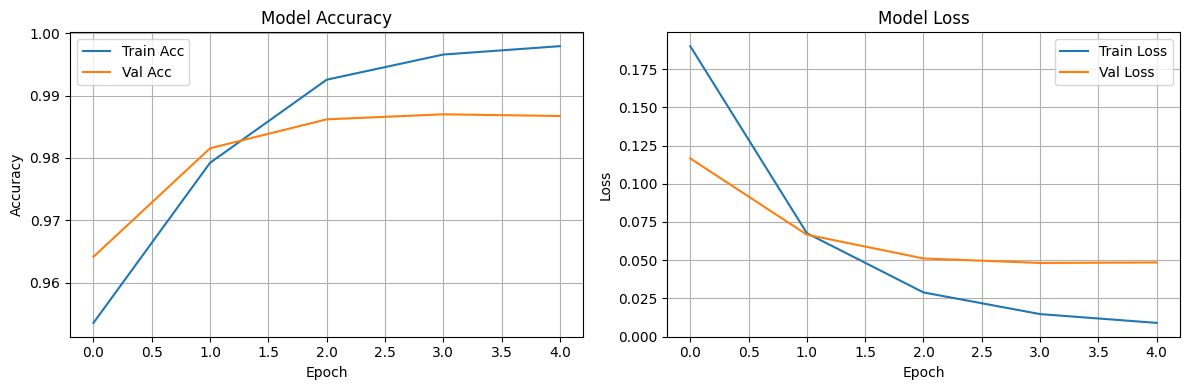

In [ ]:
# Plot training vs validation accuracy
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(bi_lstm.history['accuracy'], label='Train Acc')
plt.plot(bi_lstm.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(bi_lstm.history['loss'], label='Train Loss')
plt.plot(bi_lstm.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# predictions
y_pred = model.predict(X_val)

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step


In [ ]:
# For each token getting highest probability
y_pred_labels = np.argmax(y_pred, axis=-1)
y_true_labels = np.argmax(y_val, axis=-1)

In [ ]:
# Using the idx2label map to convert indices to strings
def decode_tags(label_indices):
    return [[idx2label[idx] for idx in sentence] for sentence in label_indices]

predicted_tags = decode_tags(y_pred_labels)
true_tags = decode_tags(y_true_labels)


In [ ]:
def show_predictions(n=3):
    for i in range(n):
        print(f"\nSentence {i+1}:")
        print("Tokens     :", val_sentences[i])
        print("True Tags  :", true_tags[i])
        print("Predicted  :", predicted_tags[i])

# first 3 samples
show_predictions(3)



Sentence 1:
Tokens     : ['CRICKET', '-', 'LEICESTERSHIRE', 'TAKE', 'OVER', 'AT', 'TOP', 'AFTER', 'INNINGS', 'VICTORY', '.']
True Tags  : ['O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted  : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Sentence 2:
Tokens     : ['LONDON', '1996-08-30']
True Tags  : ['B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted  : ['B-LOC', 

In [ ]:
# Evaluate only up to the original sentence lengths
def remove_pads(preds, labels, masks):
    clean_preds, clean_labels = [], []
    for pred_seq, label_seq, mask_seq in zip(preds, labels, masks):
        filtered_pred = []
        filtered_label = []
        for p, l, m in zip(pred_seq, label_seq, mask_seq):
            if m != 0:  # 0 = padding
                filtered_pred.append(p)
                filtered_label.append(l)
        clean_preds.append(filtered_pred)
        clean_labels.append(filtered_label)
    return clean_preds, clean_labels

# Create a mask (1 = real token, 0 = padding)
mask_val = (X_val != word2idx['PAD']).astype(int)

# Clean predictions and labels
preds_clean, labels_clean = remove_pads(predicted_tags, true_tags, mask_val)

# Calculate F1, precision, recall
print(" Evaluation Metrics:")
print("F1 Score      :", f1_score(labels_clean, preds_clean))
print("Precision     :", precision_score(labels_clean, preds_clean))
print("Recall        :", recall_score(labels_clean, preds_clean))

# Detailed per-class report
print("\n Classification Report:")
print(classification_report(labels_clean, preds_clean))


 Evaluation Metrics:
F1 Score      : 0.7671112671112672
Precision     : 0.7929970972423802
Recall        : 0.7428619986403807

 Classification Report:
              precision    recall  f1-score   support

         LOC       0.82      0.77      0.80      1830
        MISC       0.68      0.73      0.71       919
         ORG       0.77      0.72      0.74      1341
         PER       0.85      0.73      0.79      1794

   micro avg       0.79      0.74      0.77      5884
   macro avg       0.78      0.74      0.76      5884
weighted avg       0.80      0.74      0.77      5884



In [ ]:
# Flatten predictions and true labels
flat_true = [label for seq in true_tags for label in seq if label != 'O']
flat_pred = [pred for seq, true_seq in zip(predicted_tags, true_tags)
             for pred, true in zip(seq, true_seq) if true != 'O']


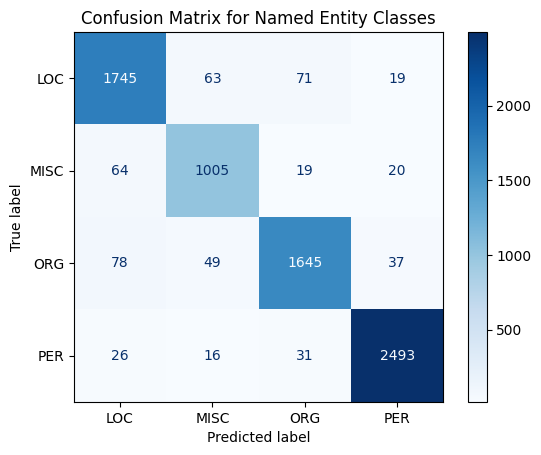

In [ ]:
# Confusion matrix
classes = ['LOC', 'MISC', 'ORG', 'PER']

# removes B- and I- prefixes
cm = confusion_matrix(
    [tag.replace('B-', '').replace('I-', '') for tag in flat_true],
    [tag.replace('B-', '').replace('I-', '') for tag in flat_pred],
    labels=classes
)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Named Entity Classes")
plt.show()
